In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuzva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuzva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_comments = pd.read_csv("./data/labeled.csv", sep=",")
data_comments['toxic'] = data_comments['toxic'].apply(int)

In [3]:
train_data_comments, test_data_comments = train_test_split(data_comments, test_size=500)

In [4]:
sentence_example = data_comments.iloc[1]['comment']
tokens = word_tokenize(sentence_example, language='russian')
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words('russian')
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [5]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [6]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [7]:
features = vectorizer.fit_transform(train_data_comments['comment'])

In [8]:
model = LogisticRegression(random_state=0)
model.fit(features, train_data_comments['toxic'])

LogisticRegression(random_state=0)

In [9]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
])

In [10]:
model_pipeline.fit(train_data_comments['comment'], train_data_comments['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000029EC2279430>)),
                ('model', LogisticRegression(random_state=0))])

In [11]:
precision_score(y_true=test_data_comments['toxic'], y_pred=model_pipeline.predict(test_data_comments['comment']))

0.9183673469387755

In [12]:
recall_score(y_true=test_data_comments['toxic'], y_pred=model_pipeline.predict(test_data_comments['comment']))

0.6338028169014085

In [13]:
prec, rec, tresholds = precision_recall_curve(y_true=test_data_comments['toxic'], probas_pred=model_pipeline.predict_proba(test_data_comments['comment'])[:, 1])

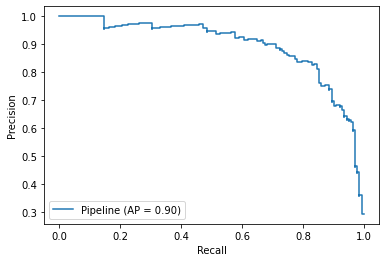

In [14]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_data_comments['comment'], y=test_data_comments['toxic'])

In [15]:
np.where(prec > 0.95)

(array([411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
        424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
        437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
        463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
        476, 477, 478, 479, 480, 481, 482, 483], dtype=int64),)

In [16]:
tresholds[411]

0.5903844962156286

In [17]:
precision_score(y_true=test_data_comments['toxic'], y_pred=model_pipeline.predict_proba(test_data_comments['comment'])[:, 1] > tresholds[411])

0.9577464788732394

In [18]:
recall_score(y_true=test_data_comments['toxic'], y_pred=model_pipeline.predict_proba(test_data_comments['comment'])[:, 1] > tresholds[411])

0.4788732394366197

In [19]:
grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', GridSearchCV(LogisticRegression(random_state=0), param_grid={'C': [0.1, 1, 10.]}, cv=3, verbose=4))
])

In [20]:
grid_pipeline.fit(train_data_comments['comment'], train_data_comments['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.685, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... C=0.1, score=0.686, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.687, total=   0.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] ................................. C=1, score=0.835, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.834, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.838, total=   0.2s
[CV] C=10.0 ..........................................................


C:\Users\yuzva\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............................. C=10.0, score=0.862, total=   0.4s
[CV] C=10.0 ..........................................................
[CV] .............................. C=10.0, score=0.860, total=   0.4s
[CV] C=10.0 ..........................................................


C:\Users\yuzva\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s finished


[CV] .............................. C=10.0, score=0.861, total=   0.4s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000029EC2CA1DC0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [21]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0, C=10))
])

In [22]:
model_pipeline_c_10.fit(train_data_comments['comment'], train_data_comments['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000029EC2690790>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [23]:
prec_c_10, rec_c_10, tresholds_c_10 = precision_recall_curve(y_true=test_data_comments['toxic'], probas_pred=model_pipeline_c_10.predict_proba(test_data_comments['comment'])[:, 1])

In [24]:
np.where(prec_c_10 > 0.95)

(array([388, 389, 390, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
        402, 403, 404, 405, 406, 407, 408, 409, 410, 420, 421, 422, 423,
        424, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437,
        438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
        451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
        464, 465, 466, 467, 468, 469, 470, 471], dtype=int64),)

In [25]:
precision_score(y_true=test_data_comments['toxic'],	y_pred=model_pipeline_c_10.predict_proba(test_data_comments['comment'])[:, 1] > tresholds_c_10[388])

0.9512195121951219

In [26]:
recall_score(y_true=test_data_comments['toxic'], y_pred=model_pipeline_c_10.predict_proba(test_data_comments['comment'])[:, 1] > tresholds_c_10[388])

0.5492957746478874